In [1]:
from os import path
import sys

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.optimize import minimize



# Third-party                                                                                                                             
import astropy.coordinates as coord
from astropy.coordinates.matrix_utilities import rotation_matrix
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from scipy.special import logsumexp
from scipy.stats import truncnorm
import emcee


from pyia import GaiaData
#import schwimmbad

import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics import mockstream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph

from potential import default_mw
from coordinates import (pal5_c, galcen_frame,
                         pal5_lead_frame, pal5_trail_frame)

from potential import get_bar_model
from coordinates import pal5_M

from gala.dynamics.mockstream.df import StreaklineStreamDF, FardalStreamDF, LagrangeCloudStreamDF
from gala.dynamics.mockstream import MockStreamGenerator

## Function that runs barred streakline models

In [2]:
def morphology(omega, RL, m_b):
    """Takes the unitless pattern speed (in km/s/kpc, and RL, which is the 
    amount of particles released per time step and the bar mass. Creates mock streams,
    outputs RA, dec to be used for track calculation"""
    static_frame = gp.StaticFrame(units=galactic)
    galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc)
    S = np.load('../data/Sn9l19m.npy') #expansion coeff.
    S = S[:6, :8, :8]
    n_steps=6000
    
    from coordinates import pal5_c
    pal5_icrs = pal5_c
    pal5_c = pal5_icrs.transform_to(gc.Pal5PriceWhelan18)
    w0 = gd.PhaseSpacePosition(pal5_c.transform_to(galcen_frame).cartesian)
    
    mw = default_mw
    pot = gp.CCompositePotential()
    pot['disk'] = mw['disk']
    pot['halo'] = mw['halo']
    RA = []
    dec = []
    for om in omega*u.km/u.s/u.kpc:
        pot['bar'] = get_bar_model(Omega=om, Snlm=S, m = m_b)
        frame = gp.ConstantRotatingFrame(Omega=[0,0,-1] * om, units=galactic)
        H = gp.Hamiltonian(pot, frame) #frame such that we're "moving" with respect to bar
        #potentials.append(H)
        df = FardalStreamDF()
        prog_pot = gp.PlummerPotential(pal5_M, 4*u.pc, units=galactic)
        gen = MockStreamGenerator(df=df, hamiltonian=pot,
                            progenitor_potential=prog_pot)
        stream_data, _ = gen.run(w0, pal5_M, dt=-0.5, n_steps=n_steps, release_every=RL)

        sim_c = stream_data.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)
        RA.append(sim_c.ra)
        dec.append(sim_c.dec)

    return RA, dec
    
    
    
    

## Functions for width and track calculations 

In [3]:

#Comapre with and wiggle of sims and data.                                                                                              
##Read in simulation RA DEC                                                                                                             
# Plot width and wiggle for all.                                                                                                        

#### Added by SP to load sims ####                                                                                                      
def lnnormal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

def ln_truncnorm(x, mu, sigma, clip_a, clip_b):
    a, b = (clip_a - mu) / sigma, (clip_b - mu) / sigma
    return truncnorm.logpdf(x, a, b, loc=mu, scale=sigma)

# 1 gaussian:                                                                                                                           
param_names = ['mu_s', 'lnstd_s']

def lnprior(p):
    mu_s, lnstd_s = p

    lp = 0

    lp += ln_truncnorm(mu_s, 0, 1, -1, 1)
    lp += ln_truncnorm(lnstd_s, -0.5, 1, -2.5, 1.5)

    return lp

def lnlike(p, phi2):
    mu_s, lnstd_s = p
    return lnnormal(phi2, mu_s, np.exp(lnstd_s))

def lnprob(p, phi2):
    lp = lnprior(p)
    if not np.all(np.isfinite(lp)):
        return -np.inf

    ll = lnlike(p, phi2).sum()
    if not np.all(np.isfinite(ll)):
        return -np.inf

    return ll + lp

## Function than calculates 1d track and width

In [9]:
def width_track(omega, RL, m_b):
    """Function takes in an array of unitless pattern speeds, an integer of released 
    particles and unitless a bar_mass, then calls stream generating function, and
    calculates the stream width and track from the simulated streams.
    The function returns width, track and morhpology of streams in separate plots. """
    
    lead_tbl = Table.read('../data/pal5_lead_samples.fits')
    bin_mask_le = np.median(lead_tbl['a'] * lead_tbl['N'][:, None], axis=1) > 50.

    trail_tbl = Table.read('../data/pal5_trail_samples.fits')
    bin_mask_tr = np.median(trail_tbl['a'] * trail_tbl['N'][:, None], axis=1) > 50.

    RA, dec = morphology(omega, RL, m_b)
        
    for j in range(len(omega)):
       
        c = coord.SkyCoord(ra=RA[j], dec=dec[j])
        c_l = c.transform_to(pal5_lead_frame)
        c_t = c.transform_to(pal5_trail_frame)

        Xl = np.stack((c_l.phi1.wrap_at(180*u.deg).degree,c_l.phi2.degree)).T
        Xt = np.stack((c_t.phi1.wrap_at(180*u.deg).degree,c_t.phi2.degree)).T


        phi1_bins = np.arange(0, 18+1e-3, 0.75)
        phi2_bins = np.arange(-2, 2+1e-3, 0.1)

        nwalkers = 64
        nburn = 128
        nsteps = 256

        phi2_min = -2.
        phi2_max = 2.

        data = dict()
        for name, X, _phi1_bins in zip(['lead', 'trail'], 
                                       [Xl, Xt], 
                                       [phi1_bins[:14], phi1_bins[:23]]):
            phi2_mask = (X[:, 1] > phi2_min) & (X[:, 1] < phi2_max)

            all_samplers = []
            Ns = []
            for i, l, r in zip(range(len(phi1_bins)-1), 
                               _phi1_bins[:-1], 
                               _phi1_bins[1:]):

                phi1_mask = (X[:, 0] > l) & (X[:, 0] <= r)
                binX = X[phi1_mask & phi2_mask]
                Ns.append((phi1_mask & phi2_mask).sum())

                H, _ = np.histogram(binX[:, 1], bins=phi2_bins)
                phi2_bin_c = 0.5*(phi2_bins[:-1]+phi2_bins[1:])
                mu = phi2_bin_c[H.argmax()]
                if np.abs(mu) > 1.:
                    mu = 0.

            # for 1-component gaussian
                p0 = (mu, np.log(0.1))

                p0s = emcee.utils.sample_ball(p0, [1e-3]*len(p0), nwalkers)

                sampler = emcee.EnsembleSampler(nwalkers, len(p0), 
                                                log_prob_fn=lnprob, 
                                                args=(binX[:, 1], ))

                pos,*_ = sampler.run_mcmc(p0s, nburn, progress=True)
                pos = emcee.utils.sample_ball(np.median(pos, axis=0), 
                                              [1e-3]*len(p0), nwalkers)
            # sampler.reset()
            # _ = sampler.run_mcmc(pos, nburn, progress=True)
                sampler.reset()
                pos,*_ = sampler.run_mcmc(pos, nburn, progress=True)
                sampler.reset()
                _ = sampler.run_mcmc(pos, nsteps, progress=True)
                print()

                all_samplers.append(sampler)

            data[name] = dict()
            data[name]['X'] = X
            data[name]['samplers'] = all_samplers
            data[name]['phi1_bins'] = _phi1_bins
            data[name]['N'] = np.array(Ns)

   

        flatchains = dict()
        for name in data:
            all_flatchains = []
            for sampler in data[name]['samplers']:
                all_flatchains.append(sampler.flatchain)

            all_flatchains = np.array(all_flatchains)

            flatchains[name] = Table()
            for k, par in enumerate(param_names):
                if par.startswith('ln_'):
                    flatchains[name][par] = all_flatchains[..., k]
                    flatchains[name][par[3:]] = np.exp(all_flatchains[..., k])
                elif par.startswith('ln'):
                    flatchains[name][par] = all_flatchains[..., k]
                    flatchains[name][par[2:]] = np.exp(all_flatchains[..., k])
                else:
                    flatchains[name][par] = all_flatchains[..., k]

            phi1_bin_c = 0.5 * (data[name]['phi1_bins'][:-1] + data[name]['phi1_bins'][1:]) * u.deg
            flatchains[name]['phi1_bin_c'] = phi1_bin_c
            flatchains[name]['N'] = data[name]['N']
        
        
    ###w = witdth, t = track
        med_le_w = np.median(lead_tbl['std_s'], axis=1)
        err1_le_w = med_le_w - np.percentile(lead_tbl['std_s'], 16, axis=1)
        err2_le_w = np.percentile(lead_tbl['std_s'], 84, axis=1) - med_le_w

        med_tr_w = np.median(trail_tbl['std_s'], axis=1)
        err1_tr_w = med_tr_w - np.percentile(trail_tbl['std_s'], 16, axis=1)
        err2_tr_w = np.percentile(trail_tbl['std_s'], 84, axis=1) - med_tr_w
           
        
        
        med_le_t = np.median(lead_tbl['mu_s'], axis=1)
        err1_le_t = med_le_t - np.percentile(lead_tbl['mu_s'], 16, axis=1)
        err2_le_t = np.percentile(lead_tbl['mu_s'], 84, axis=1) - med_le_t

        med_tr_t = np.median(trail_tbl['mu_s'], axis=1)
        err1_tr_t = med_tr_t - np.percentile(trail_tbl['mu_s'], 16, axis=1)
        err2_tr_t = np.percentile(trail_tbl['mu_s'], 84, axis=1) - med_tr_t


        
        
        #Now plotting everything 
        mpl.rcParams.update({'font.size': 24})
        label_size = 20
        mpl.rcParams['xtick.labelsize'] = 18#label_size                                                  
        mpl.rcParams['ytick.labelsize'] = 18#label_size 
        fig,axes = plt.subplots(1, 3,figsize=(21,7))#), sharex=True)
        
                                #
                                
        #stream morphology                        
        axes[0].scatter(RA[j], dec[j], s=0.01, color='black', label = 'Mb = '+ '%.2E' % Decimal(m_b) + ' Om = '+ str(omega[j]) + ' km/s/kpc' , marker='.', rasterized=True)
        axes[0].set_xlim(250,215)
        axes[0].set_ylabel('Dec [deg]')
        axes[0].set_yticks([-10,-5,0,5, 10])
        axes[0].set_ylim(-10,10)
        axes[0].set_aspect('equal')
        axes[0].legend(fontsize=16, loc='upper right')

            
           
        for name in data.keys():
            flatchain = flatchains[name]
            med = np.median(flatchain['std_s'], axis=1)
            axes[1].plot(flatchains[name]['phi1_bin_c'], med, linestyle='--', label='sim: '+name)

        axes[1].errorbar(lead_tbl['phi1_bin_c'][bin_mask_le],
                         med_le_w[bin_mask_le],
                         yerr=(err1_le_w[bin_mask_le], err2_le_w[bin_mask_le]),
                         marker='o', ls='none',ecolor='steelblue', color='steelblue',label='data: lead')

        axes[1].errorbar(trail_tbl['phi1_bin_c'][bin_mask_tr],
                         med_tr_w[bin_mask_tr],
                         yerr=(err1_tr_w[bin_mask_tr], err2_tr_w[bin_mask_tr]),
                         marker='o', ls='none', ecolor='orange', color='orange',label='data: trail')


        axes[1].set_xlim(0, 17)
        axes[1].set_ylim(0, 0.6)
        axes[1].set_xlabel(r'$\Delta \phi_1$ [deg]')
        axes[1].set_ylabel(r'$\sigma$ [deg]')
        axes[1].legend(loc='best', fontsize=15) 


        for name in data.keys():
            flatchain = flatchains[name]
            med = np.median(flatchain['mu_s'], axis=1)
            axes[2].plot(flatchain['phi1_bin_c'], med, linestyle='--', label='sim: '+name)


        axes[2].errorbar(lead_tbl['phi1_bin_c'][bin_mask_le],
                         med_le_t[bin_mask_le],
                         yerr=(err1_le_t[bin_mask_le], err2_le_t[bin_mask_le]),
                         marker='o', ls='none',ecolor='steelblue', color='steelblue',label='data: lead')



        axes[2].errorbar(trail_tbl['phi1_bin_c'][bin_mask_tr],
                        med_tr_t[bin_mask_tr],
                        yerr=(err1_tr_t[bin_mask_tr], err2_tr_t[bin_mask_tr]),
                        marker='o', ls='none', ecolor='orange', color='orange',label='data: trail')


        axes[2].set_xlim(0, 17)
        axes[2].set_ylim(-1, 1)
        axes[2].set_xlabel(r'$\Delta \phi_1$ [deg]')
        axes[2].set_ylabel('$\Delta \phi_2$ [deg]')
        axes[2].legend(loc='best', fontsize=15)
    
        fig.tight_layout()                                                                                                                                                                                          
        fig.savefig('BarModels_RL' + str(RL) + '_Mb' + '%.2E' % Decimal(m_b) + '_Om'+ str(omega[j]) + '.png')

            
            
        #need to return RA dec and everyhing I need to plot for width and wiggle
       # return RA, dec, med_le_w , err1_le_w, err2_le_w, med_tr_w, err1_tr_w , err2_tr_w,\
        ##med_le_t ,err1_le_t,err2_le_t,  med_tr_t ,err1_tr_t, err2_tr_t,  lead_tbl ,bin_mask_le ,\
       # trail_tbl,  bin_mask_tr , data, flatchains
 
    




In [5]:
#I need to only use one bar mass.....

## Call function 

  4%|▍         | 5/128 [00:00<00:02, 44.95it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.37it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.34it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.66it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.62it/s]

  4%|▍         | 5/128 [00:00<00:02, 42.99it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.63it/s]

  4%|▍         | 5/128 [00:00<00:02, 43.11it/s]

  4%|▍         | 5/128 [00:00<00:02, 44.87it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.91it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.42it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.19it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.85it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.13it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.16it/s]

  4%|▍         | 5/128 [00:00<00:02, 44.23it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.32it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.70it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.61it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.32it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.74it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.32it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.56it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.16it/s]

  4%|▍         | 5/128 [00:00<00:02, 43.14it/s]

  4%|▍         | 5/128 [00:00<00:02, 45.41it/s]

100%|██████████| 256/256 [00:05<00:00, 45.68it/s]


NameError: name 'Decimal' is not defined

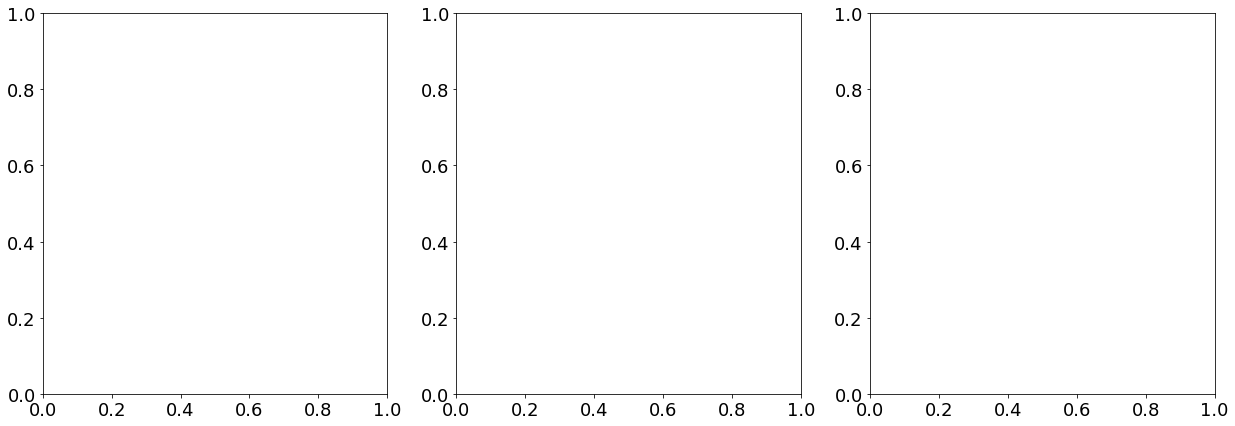

In [10]:
omega = np.array([44])

#plot_morph_track_width(omega, RL=10, m_b=1e10)

width_track(omega, RL=10, m_b=1e10)

## Funcition that creates final plot of morphology, track, width given $\Omega_b$

In [ ]:
#I did this in a separate function below first. 

In [ ]:
# def plot_morph_track_width(omega, RL, m_b):
#     mpl.rcParams.update({'font.size': 24})
#     label_size = 20
#     mpl.rcParams['xtick.labelsize'] = 18#label_size                                                  
#     mpl.rcParams['ytick.labelsize'] = 18#label_size     
    
#     RA, dec, med_le_w , err1_le_w, err2_le_w, med_tr_w, err1_tr_w , err2_tr_w,\
#         med_le_t ,err1_le_t,err2_le_t,  med_tr_t ,err1_tr_t, err2_tr_t,  lead_tbl ,bin_mask_le ,\
#         trail_tbl,  bin_mask_tr,data, flatchains = width_track(omega, RL, m_b)
    
#    # print(flatchains)
#    # print(flatchains.shape)
#     from decimal import Decimal
    
#     for j in range(len(omega)):
#         fig,axes = plt.subplots(1, 3,figsize=(21,7))#), sharex=True)
        
#                                 #
                                
#         #stream morphology                        
#         axes[0].scatter(RA[j], dec[j], s=0.01, color='black', label = 'Mb = '+ '%.2E' % Decimal(m_b) + ' Om = '+ str(omega[j]) + ' km/s/kpc' , marker='.', rasterized=True)
#         axes[0].set_xlim(250,215)
#         axes[0].set_ylabel('Dec [deg]')
#         axes[0].set_yticks([-10,-5,0,5, 10])
#         axes[0].set_ylim(-10,10)
#         axes[0].set_aspect('equal')
#         axes[0].legend(fontsize=16, loc='upper right')


            
           
#         for name in data.keys():
#             flatchain = flatchains[name]
#             med = np.median(flatchain['std_s'], axis=1)
#             axes[1].plot(flatchains[name]['phi1_bin_c'], med, linestyle='--', label='sim: '+name)

#         axes[1].errorbar(lead_tbl['phi1_bin_c'][bin_mask_le],
#                          med_le_w[bin_mask_le],
#                          yerr=(err1_le_w[bin_mask_le], err2_le_w[bin_mask_le]),
#                          marker='o', ls='none',ecolor='steelblue', color='steelblue',label='data: lead')

#         axes[1].errorbar(trail_tbl['phi1_bin_c'][bin_mask_tr],
#                          med_tr_w[bin_mask_tr],
#                          yerr=(err1_tr_w[bin_mask_tr], err2_tr_w[bin_mask_tr]),
#                          marker='o', ls='none', ecolor='orange', color='orange',label='data: trail')


#         axes[1].set_xlim(0, 17)
#         axes[1].set_ylim(0, 0.6)
#         axes[1].set_xlabel(r'$\Delta \phi_1$ [deg]')
#         axes[1].set_ylabel(r'$\sigma$ [deg]')
#         axes[1].legend(loc='best', fontsize=15) 



#         for name in data.keys():
#             flatchain = flatchains[name]
#             med = np.median(flatchain['mu_s'], axis=1)
#             axes[2].plot(flatchain['phi1_bin_c'], med, linestyle='--', label='sim: '+name)


#         axes[2].errorbar(lead_tbl['phi1_bin_c'][bin_mask_le],
#                          med_le_t[bin_mask_le],
#                          yerr=(err1_le_t[bin_mask_le], err2_le_t[bin_mask_le]),
#                          marker='o', ls='none',ecolor='steelblue', color='steelblue',label='data: lead')



#         axes[2].errorbar(trail_tbl['phi1_bin_c'][bin_mask_tr],
#                         med_tr_t[bin_mask_tr],
#                         yerr=(err1_tr_t[bin_mask_tr], err2_tr_t[bin_mask_tr]),
#                         marker='o', ls='none', ecolor='orange', color='orange',label='data: trail')


#         axes[2].set_xlim(0, 17)
#         axes[2].set_ylim(-1, 1)
#         axes[2].set_xlabel(r'$\Delta \phi_1$ [deg]')
#         axes[2].set_ylabel('$\Delta \phi_2$ [deg]')
#         axes[2].legend(loc='best', fontsize=15)
    
#         fig.tight_layout()                                                                                                                                                                                          
#         fig.savefig('MorphologyTrackWidth/BarModels_RL' + str(RL) + '_Mb' + '%.2E' % Decimal(m_b) + '_Om'+ str(omega[j]) + '.png')

